In [ ]:
# Install all required libraries using python -m pip (works even if pip not in PATH)
import sys
!{sys.executable} -m pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cpu
!{sys.executable} -m pip install transformers pillow matplotlib numpy -q

# Import Data

In [ ]:
import os
import torch
import torchvision
from torchvision import transforms, models
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt

# Data paths - updated to use local segmented_folder
segmented = './segmented_folder'
apple_black_rot = './segmented_folder/Apple___Black_rot'
apple_healthy = './segmented_folder/Apple___healthy'

# Verify the data path exists
if os.path.exists(segmented):
    print(f"✓ Data directory found: {segmented}")
    # Count number of classes
    classes = [d for d in os.listdir(segmented) if os.path.isdir(os.path.join(segmented, d))]
    print(f"✓ Number of classes: {len(classes)}")
    print(f"✓ Classes: {classes[:5]}...")  # Show first 5 classes
else:
    print(f"✗ Data directory not found: {segmented}")
    print("Please ensure the segmented_folder is in the same directory as this notebook.")

In [ ]:
train_transforms =  transforms.Compose([
    transforms.RandomResizedCrop(32),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(degrees = 45),
    transforms.ToTensor(),  # Converts PIL Image to tensor and scales to [0, 1]
])

In [ ]:
val_transforms = transforms.Compose([
    transforms.ToTensor(),  # Converts PIL Image to tensor and scales to [0, 1]
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [ ]:
try:
    file = ImageFolder(root = segmented, transform = train_transforms)
    old_file = ImageFolder(root = segmented, transform = val_transforms )
    # file = ImageFolder(root = apple_black_rot)
    # apple_h = ImageFolder(root = apple_healthy)

except FileNotFoundError:
    print("File not found")


# Splitting the dataset

In [ ]:
train_size = int(0.8 * len(file))
test_size = int(0.1 * len (file))
valid_size = len(file ) - test_size - train_size

train_dataset, test_dataset, valid_dataset = torch.utils.data.random_split(file, [train_size, test_size, valid_size])

BATCH_SIZE = 32

In [ ]:
train_loader = DataLoader(
    dataset = train_dataset,
    batch_size = BATCH_SIZE,
    shuffle = False
)

test_loader = DataLoader(
    dataset = test_dataset,
    batch_size = BATCH_SIZE,
    shuffle = False
)
valid_loader = DataLoader(
    dataset = valid_dataset,
    batch_size = BATCH_SIZE,
    shuffle = False
)

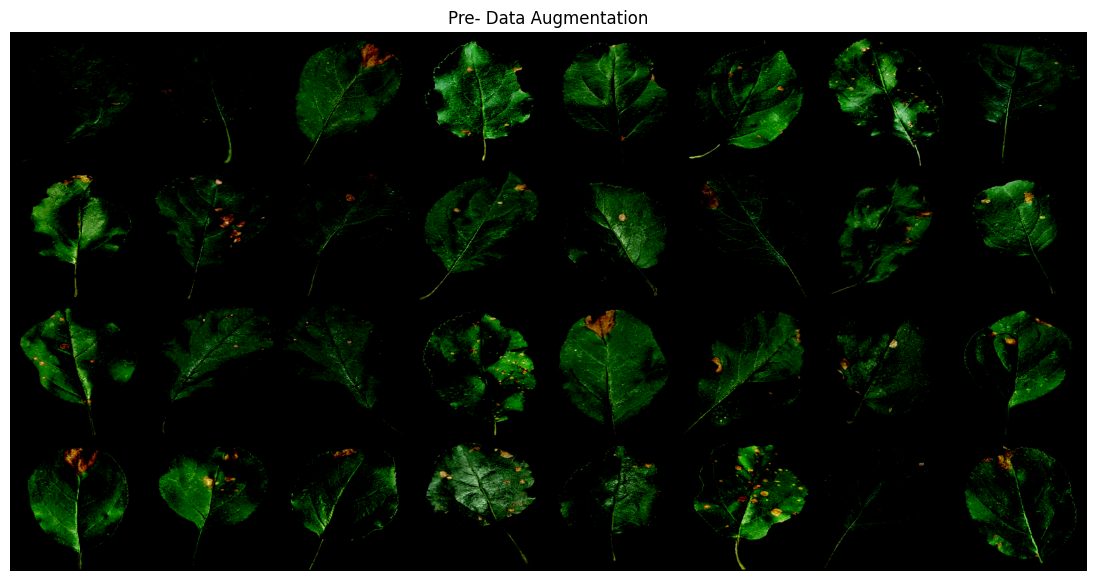

In [ ]:
pre_aug =  DataLoader(
    dataset = old_file,
    batch_size = BATCH_SIZE,
    shuffle = False
)
image, label = next(iter(pre_aug))
grid = torchvision.utils.make_grid(image)
plt.figure(figsize=(15, 7))

# Transpose the grid from (C, H, W) to (H, W, C) for matplotlib
plt.imshow(grid.permute(1, 2, 0))

plt.title("Pre- Data Augmentation")
plt.axis('off')
plt.show()

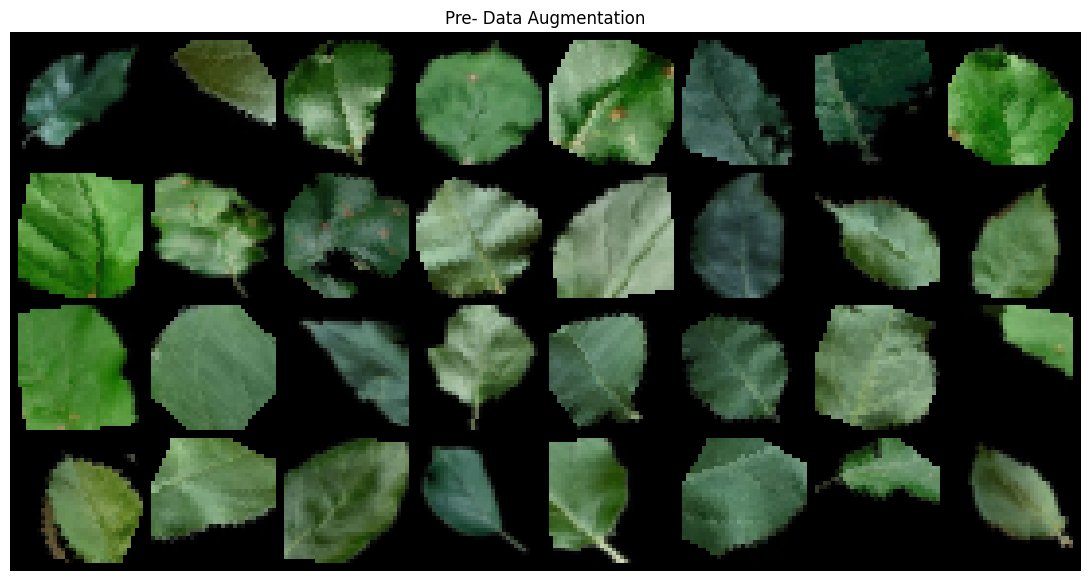

In [ ]:
MEAN = torch.tensor([0.485, 0.456, 0.406])
STD = torch.tensor([0.229, 0.224, 0.225])

image, label = next(iter(train_loader))
grid = torchvision.utils.make_grid(image)
plt.figure(figsize=(15, 7))

# Transpose the grid from (C, H, W) to (H, W, C) for matplotlib
plt.imshow(grid.permute(1, 2, 0))

plt.title("Pre- Data Augmentation")
plt.axis('off')
plt.show()

# Augmenting Data 
Performing transformations on data helps:
* prevent overfitting
* expands the diversity of dataset
* robust + generalize 

In [ ]:
weights = models.MobileNet_V3_Small_Weights.DEFAULT
model = models.mobilenet_v3_small(weights = weights )

# Binary Classification with Hugging Face ResNet

Binary classification: Healthy vs Diseased plants

In [ ]:
# Install required libraries for Hugging Face ResNet
import sys
!{sys.executable} -m pip install transformers -q

from transformers import AutoImageProcessor, ResNetForImageClassification
import torch.nn as nn
import torch.optim as optim

In [ ]:
# Create binary classification dataset wrapper using your existing 'file' ImageFolder
# This reuses your existing dataset and just remaps the labels to binary (0=healthy, 1=diseased)
class BinaryLabelWrapper(Dataset):
    """
    Wraps existing ImageFolder dataset to convert multi-class labels to binary.
    0 = Healthy, 1 = Diseased
    """
    def __init__(self, dataset):
        self.dataset = dataset
        # Get class names from ImageFolder
        self.class_names = dataset.classes
        print(f"Original classes: {len(self.class_names)}")
        print(f"Sample classes: {self.class_names[:5]}")
        
        # Count healthy vs diseased
        healthy_count = sum(1 for cls in self.class_names if 'healthy' in cls.lower())
        print(f"\nHealthy classes: {healthy_count}")
        print(f"Diseased classes: {len(self.class_names) - healthy_count}")
    
    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, idx):
        image, original_label = self.dataset[idx]
        # Convert to binary: 0 if 'healthy' in class name, else 1
        class_name = self.class_names[original_label]
        binary_label = 0 if 'healthy' in class_name.lower() else 1
        return image, binary_label

# Wrap your existing 'file' dataset with binary labels
print("Creating binary classification wrapper from existing dataset...")
binary_file = BinaryLabelWrapper(file)

In [ ]:
# Reuse your existing train/test/valid split proportions and BATCH_SIZE
# Split the binary dataset using the same ratios you defined earlier
binary_train_size = int(0.8 * len(binary_file))
binary_test_size = int(0.1 * len(binary_file))
binary_valid_size = len(binary_file) - binary_train_size - binary_test_size

binary_train_dataset, binary_test_dataset, binary_valid_dataset = torch.utils.data.random_split(
    binary_file, [binary_train_size, binary_test_size, binary_valid_size]
)

# Create data loaders using your existing BATCH_SIZE
binary_train_loader = DataLoader(
    dataset=binary_train_dataset,
    batch_size=BATCH_SIZE,  # Reusing your BATCH_SIZE from cell 7
    shuffle=True
)

binary_test_loader = DataLoader(
    dataset=binary_test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False
)

binary_valid_loader = DataLoader(
    dataset=binary_valid_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False
)

print(f"Binary train size: {binary_train_size}")
print(f"Binary test size: {binary_test_size}")
print(f"Binary validation size: {binary_valid_size}")
print(f"Batch size: {BATCH_SIZE}")

In [ ]:
# Load pre-trained ResNet from Hugging Face
model_name = "microsoft/resnet-50"

# NOTE: ResNet expects 224x224 images, but your existing transforms use 32x32
# The model will automatically resize, but for better results, consider updating 
# train_transforms in cell 3 to use RandomResizedCrop(224) instead of (32)

# Load the ResNet model for binary classification
resnet_model = ResNetForImageClassification.from_pretrained(
    model_name,
    num_labels=1,  # Binary classification with single output + sigmoid
    ignore_mismatched_sizes=True
)

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

resnet_model = resnet_model.to(device)

print(f"\nModel: {model_name}")
print(f"Total parameters: {sum(p.numel() for p in resnet_model.parameters()):,}")
print(f"Trainable parameters: {sum(p.numel() for p in resnet_model.parameters() if p.requires_grad):,}")

print("\n⚠ NOTE: Your current transforms use 32x32 images.")
print("ResNet works best with 224x224. Consider updating cell 3:")
print("  Change: transforms.RandomResizedCrop(32)")
print("  To:     transforms.RandomResizedCrop(224)")

In [ ]:
# Binary Cross Entropy Loss with Sigmoid
# BCEWithLogitsLoss = sigmoid + BCELoss (more numerically stable)
criterion = nn.BCEWithLogitsLoss()

# Optimizer
optimizer = optim.Adam(resnet_model.parameters(), lr=0.0001)

print("Loss Function: BCEWithLogitsLoss")
print("  - Combines sigmoid activation + binary cross entropy")
print("  - Formula: -[y*log(sigmoid(x)) + (1-y)*log(1-sigmoid(x))]")
print(f"\nOptimizer: Adam (lr=0.0001)")
print(f"Criterion: {criterion}")

In [ ]:
# Training function
def train_binary_classifier(model, train_loader, val_loader, criterion, optimizer, num_epochs=5):
    """
    Train binary classifier with BCE loss and sigmoid activation
    """
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []
    
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        for batch_idx, (images, labels) in enumerate(train_loader):
            images = images.to(device)
            labels = labels.to(device).float().unsqueeze(1)  # Shape: (batch_size, 1)
            
            # Forward pass
            outputs = model(images).logits  # ResNet outputs logits
            loss = criterion(outputs, labels)
            
            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            # Statistics
            running_loss += loss.item()
            
            # Apply sigmoid to get probabilities
            predictions = torch.sigmoid(outputs) > 0.5
            correct += (predictions == labels).sum().item()
            total += labels.size(0)
            
            if batch_idx % 10 == 0:
                print(f"Epoch [{epoch+1}/{num_epochs}], Batch [{batch_idx}/{len(train_loader)}], "
                      f"Loss: {loss.item():.4f}")
        
        # Calculate epoch metrics
        epoch_loss = running_loss / len(train_loader)
        epoch_acc = 100 * correct / total
        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_acc)
        
        # Validation phase
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        
        with torch.no_grad():
            for images, labels in val_loader:
                images = images.to(device)
                labels = labels.to(device).float().unsqueeze(1)
                
                outputs = model(images).logits
                loss = criterion(outputs, labels)
                
                val_loss += loss.item()
                predictions = torch.sigmoid(outputs) > 0.5
                val_correct += (predictions == labels).sum().item()
                val_total += labels.size(0)
        
        val_epoch_loss = val_loss / len(val_loader)
        val_epoch_acc = 100 * val_correct / val_total
        val_losses.append(val_epoch_loss)
        val_accuracies.append(val_epoch_acc)
        
        print(f"\nEpoch [{epoch+1}/{num_epochs}] Summary:")
        print(f"  Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.2f}%")
        print(f"  Val Loss: {val_epoch_loss:.4f}, Val Acc: {val_epoch_acc:.2f}%")
        print("-" * 60)
    
    return train_losses, val_losses, train_accuracies, val_accuracies

In [ ]:
# Train the model (uncomment to run training)
# train_losses, val_losses, train_accs, val_accs = train_binary_classifier(
#     model=resnet_model,
#     train_loader=binary_train_loader,
#     val_loader=binary_valid_loader,
#     criterion=criterion,
#     optimizer=optimizer,
#     num_epochs=5
# )

print("To train the model, uncomment the code above and run this cell")
print("Training will take time depending on your hardware (GPU recommended)")

In [ ]:
# Visualize the sigmoid loss function
import numpy as np

# Create a range of logits (raw outputs before sigmoid)
logits = np.linspace(-10, 10, 1000)

# Apply sigmoid function: σ(x) = 1 / (1 + e^(-x))
sigmoid_outputs = 1 / (1 + np.exp(-logits))

# Binary Cross Entropy Loss for y=1 and y=0
# BCE Loss = -[y*log(p) + (1-y)*log(1-p)] where p = sigmoid(logit)
epsilon = 1e-7  # For numerical stability
loss_when_y1 = -np.log(sigmoid_outputs + epsilon)  # When true label is 1
loss_when_y0 = -np.log(1 - sigmoid_outputs + epsilon)  # When true label is 0

# Plot
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Plot 1: Sigmoid function
axes[0].plot(logits, sigmoid_outputs, linewidth=2, color='blue')
axes[0].axhline(y=0.5, color='red', linestyle='--', alpha=0.5, label='Decision boundary (0.5)')
axes[0].axvline(x=0, color='gray', linestyle='--', alpha=0.3)
axes[0].set_xlabel('Logits (Raw Model Output)', fontsize=12)
axes[0].set_ylabel('Sigmoid Output (Probability)', fontsize=12)
axes[0].set_title('Sigmoid Activation Function\nσ(x) = 1 / (1 + e^(-x))', fontsize=14, fontweight='bold')
axes[0].grid(True, alpha=0.3)
axes[0].legend()

# Plot 2: BCE Loss when true label = 1 (Diseased)
axes[1].plot(logits, loss_when_y1, linewidth=2, color='red')
axes[1].set_xlabel('Logits (Raw Model Output)', fontsize=12)
axes[1].set_ylabel('Loss Value', fontsize=12)
axes[1].set_title('BCE Loss when True Label = 1 (Diseased)\nLoss = -log(sigmoid(x))', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3)
axes[1].set_ylim([0, 5])

# Plot 3: BCE Loss when true label = 0 (Healthy)
axes[2].plot(logits, loss_when_y0, linewidth=2, color='green')
axes[2].set_xlabel('Logits (Raw Model Output)', fontsize=12)
axes[2].set_ylabel('Loss Value', fontsize=12)
axes[2].set_title('BCE Loss when True Label = 0 (Healthy)\nLoss = -log(1 - sigmoid(x))', fontsize=14, fontweight='bold')
axes[2].grid(True, alpha=0.3)
axes[2].set_ylim([0, 5])

plt.tight_layout()
plt.show()

# Print explanation
print("=" * 80)
print("SIGMOID AND BINARY CROSS ENTROPY LOSS EXPLANATION")
print("=" * 80)
print("\n1. SIGMOID FUNCTION:")
print("   σ(x) = 1 / (1 + e^(-x))")
print("   - Maps any real number to range (0, 1)")
print("   - Output represents probability of class 1 (diseased)")
print("   - Decision boundary at 0.5 (when logit = 0)")
print("\n2. BINARY CROSS ENTROPY LOSS:")
print("   BCE = -[y*log(σ(x)) + (1-y)*log(1-σ(x))]")
print("   - When y=1 (diseased): Loss = -log(σ(x))")
print("   - When y=0 (healthy): Loss = -log(1-σ(x))")
print("   - Loss is low when prediction matches true label")
print("   - Loss is high when prediction is wrong")
print("\n3. BCEWithLogitsLoss in PyTorch:")
print("   - Combines sigmoid + BCE in one operation")
print("   - More numerically stable than separate operations")
print("   - Takes raw logits as input (no sigmoid needed)")
print("=" * 80)